# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [52]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

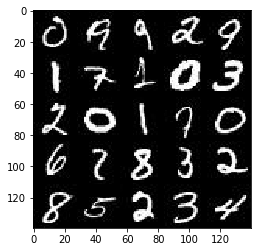

In [53]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

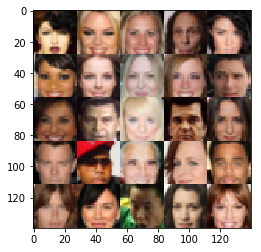

In [54]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [55]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [56]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs = tf.placeholder(tf.float32,shape=[None,image_width,image_height,image_channels])
    zInputs = tf.placeholder(tf.float32,shape=[None, z_dim])
    learningRate = tf.placeholder(tf.float32)

    return inputs, zInputs, learningRate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [57]:
import numpy as np

def lrelu(x, alpha=0.1):
    return tf.maximum(alpha * x, x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = lrelu(conv1)
        relu1 = tf.nn.dropout(relu1, 0.8)
        # 14x14x64

        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        batchNormalization2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = lrelu(batchNormalization2)
        relu2 = tf.nn.dropout(relu2, 0.8)
        # 7x7x128
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        batchNormalization3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = lrelu(batchNormalization3)
        relu3 = tf.nn.dropout(relu3, 0.8)
        # 4x4x256

        conv4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        batchNormalization4 = tf.layers.batch_normalization(conv4, training=True)
        relu4 = lrelu(batchNormalization4)
        relu4 = tf.nn.dropout(relu4, 0.8)
        # 2x2x512

        dimensions = np.product(relu4.get_shape().as_list()[1:])
        flat = tf.reshape(relu4, (-1, dimensions))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [58]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        hiddenLayer1 = tf.layers.dense(z, 7*7*512)
        hiddenLayer1 = tf.reshape(hiddenLayer1, (-1, 7, 7, 512))
        hiddenLayer1 = tf.layers.batch_normalization(hiddenLayer1, training=is_train)
        hiddenLayer1 = lrelu(hiddenLayer1)

        hiddenLayer2 = tf.layers.conv2d_transpose(hiddenLayer1, 256, 5, strides=2, padding='same')
        hiddenLayer2 = tf.layers.batch_normalization(hiddenLayer2, training=is_train)
        hiddenLayer2 = lrelu(hiddenLayer2)
        # 14x14x256
        
        hiddenLayer3 = tf.layers.conv2d_transpose(hiddenLayer2, 512, 5, strides=2, padding='same')
        hiddenLayer3 = tf.layers.batch_normalization(hiddenLayer3, training=is_train)
        hiddenLayer3 = lrelu(hiddenLayer3)
        # 28x28x512

        hiddenLayer4 = tf.layers.conv2d_transpose(hiddenLayer3, 64, 5, strides=1, padding='same')
        hiddenLayer4 = tf.layers.batch_normalization(hiddenLayer4, training=is_train)
        hiddenLayer4 = lrelu(hiddenLayer4)
        # 28x28x1024
        
        logits = tf.layers.conv2d(hiddenLayer4, out_channel_dim, 5, strides=1, padding='same')

        return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [65]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gModel = generator(input_z, out_channel_dim)
    dModelReal, dLogitsReal = discriminator(input_real,reuse=False)
    dModelFake, dLogitsFake = discriminator(gModel,reuse=True)

    # Label-smoothing
    dLossReal = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dLogitsReal,labels=tf.ones_like(dModelReal) * np.random.uniform(.7, 1.2)))
    dLossFake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dLogitsFake,labels=tf.zeros_like(dModelFake) + np.random.uniform(0, .3)))
    gLoss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dLogitsFake,labels=tf.ones_like(dModelFake)))
    dLoss = dLossReal + dLossFake

    return dLoss, gLoss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [60]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    vs = tf.trainable_variables()
    dVariables = [v for v in vs if v.name.startswith('discriminator')]
    gVariables = [v for v in vs if v.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        dTrainingOperation = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=dVariables)
        gTrainingOperation = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=gVariables)

    return dTrainingOperation, gTrainingOperation

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)


Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [61]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [63]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    sampleZ = np.random.uniform(-1, 1, size=(72, z_dim))
    imageWidth, imageHeight, imageChannels = data_shape[1:]
    inputReal, inputZ, lr = model_inputs(imageWidth, imageHeight, imageChannels, z_dim)
    dLoss, gLoss = model_loss(inputReal, inputZ, imageChannels)
    dOpt, gOpt = model_opt(dLoss, gLoss, learning_rate, 0.5)

    steps = 0
    showEvery = 100
    printEvery = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batchImages in get_batches(batch_size):
                steps += 1
                batchImages *= 2
                batchZ = np.random.uniform(-1,1,size=(batch_size, z_dim))

                sess.run(dOpt, feed_dict={inputReal: batchImages,inputZ: batchZ})

                sess.run(gOpt, feed_dict={inputReal: batchImages,inputZ: batchZ})

                sess.run(gOpt, feed_dict={inputReal: batchImages,inputZ: batchZ})

                if steps % printEvery == 0:
                    trainLossD = dLoss.eval({inputZ: batchZ,inputReal: batchImages})
                    trainLossG = gLoss.eval({inputZ: batchZ})

                    print("Epoch {}/{},".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f},".format(trainLossD),
                          "Generator Loss: {:.4f}".format(trainLossG))
                    
                if steps % showEvery == 0:
                    gen_samples = sess.run(generator(inputZ,imageChannels,False),feed_dict={inputZ: batchZ})

                    show_generator_output(sess,24,inputZ,imageChannels,data_image_mode)

        print('Result after training:')
        gen_samples = sess.run(
            generator(inputZ,imageChannels,False),feed_dict={inputZ: batchZ})

        show_generator_output(sess,24,inputZ,imageChannels,data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2, Discriminator Loss: 2.1759, Generator Loss: 0.7716
Epoch 1/2, Discriminator Loss: 1.7378, Generator Loss: 0.6740
Epoch 1/2, Discriminator Loss: 1.6489, Generator Loss: 0.5325
Epoch 1/2, Discriminator Loss: 1.6205, Generator Loss: 0.5489


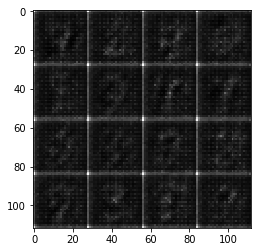

Epoch 1/2, Discriminator Loss: 1.4683, Generator Loss: 0.8786
Epoch 1/2, Discriminator Loss: 1.5499, Generator Loss: 0.7371
Epoch 1/2, Discriminator Loss: 1.4561, Generator Loss: 0.9414
Epoch 1/2, Discriminator Loss: 1.4448, Generator Loss: 0.6943


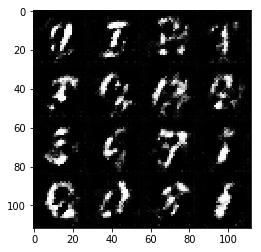

Epoch 1/2, Discriminator Loss: 1.4444, Generator Loss: 0.7194
Epoch 1/2, Discriminator Loss: 1.3669, Generator Loss: 0.9145
Epoch 1/2, Discriminator Loss: 1.4053, Generator Loss: 0.8153
Epoch 1/2, Discriminator Loss: 1.4650, Generator Loss: 0.8224


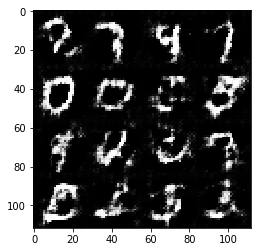

Epoch 1/2, Discriminator Loss: 1.3847, Generator Loss: 0.8102
Epoch 1/2, Discriminator Loss: 1.6022, Generator Loss: 0.5771
Epoch 1/2, Discriminator Loss: 1.3726, Generator Loss: 0.9311
Epoch 1/2, Discriminator Loss: 1.3895, Generator Loss: 0.9731


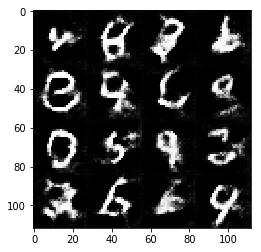

Epoch 1/2, Discriminator Loss: 1.3990, Generator Loss: 0.7942
Epoch 1/2, Discriminator Loss: 1.4976, Generator Loss: 0.7014
Epoch 1/2, Discriminator Loss: 1.4477, Generator Loss: 0.8415
Epoch 1/2, Discriminator Loss: 1.4658, Generator Loss: 0.8291


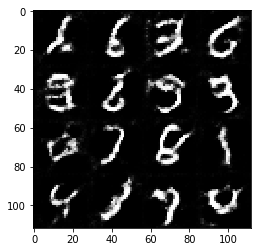

Epoch 1/2, Discriminator Loss: 1.5820, Generator Loss: 0.5738
Epoch 1/2, Discriminator Loss: 1.4010, Generator Loss: 0.7371
Epoch 1/2, Discriminator Loss: 1.5205, Generator Loss: 0.5916
Epoch 1/2, Discriminator Loss: 1.3835, Generator Loss: 0.9277


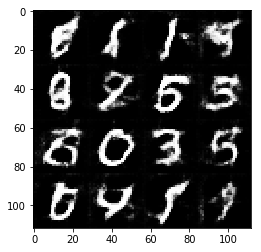

Epoch 1/2, Discriminator Loss: 1.5790, Generator Loss: 0.6678
Epoch 1/2, Discriminator Loss: 1.4697, Generator Loss: 0.5943
Epoch 1/2, Discriminator Loss: 1.4466, Generator Loss: 0.8091
Epoch 1/2, Discriminator Loss: 1.3621, Generator Loss: 0.8015


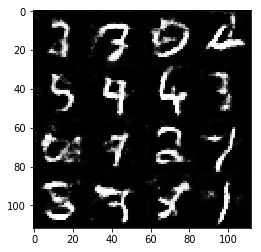

Epoch 1/2, Discriminator Loss: 1.5319, Generator Loss: 0.9124
Epoch 1/2, Discriminator Loss: 1.4380, Generator Loss: 0.7774
Epoch 1/2, Discriminator Loss: 1.4731, Generator Loss: 0.6925
Epoch 1/2, Discriminator Loss: 1.4464, Generator Loss: 0.7493


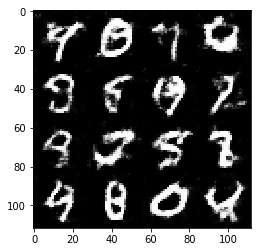

Epoch 1/2, Discriminator Loss: 1.5529, Generator Loss: 0.6022
Epoch 1/2, Discriminator Loss: 1.5994, Generator Loss: 0.6564
Epoch 1/2, Discriminator Loss: 1.4409, Generator Loss: 0.7845
Epoch 1/2, Discriminator Loss: 1.5126, Generator Loss: 0.7627


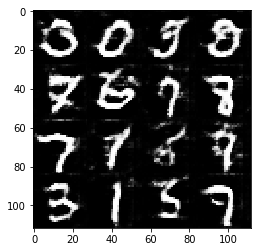

Epoch 1/2, Discriminator Loss: 1.5217, Generator Loss: 0.7671
Epoch 2/2, Discriminator Loss: 1.5506, Generator Loss: 0.8793
Epoch 2/2, Discriminator Loss: 1.4536, Generator Loss: 0.7763
Epoch 2/2, Discriminator Loss: 1.5459, Generator Loss: 0.6406


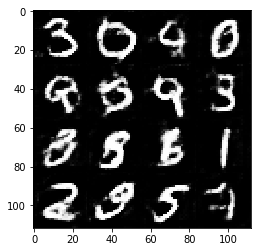

Epoch 2/2, Discriminator Loss: 1.4140, Generator Loss: 0.8533
Epoch 2/2, Discriminator Loss: 1.5918, Generator Loss: 0.7359
Epoch 2/2, Discriminator Loss: 1.4863, Generator Loss: 0.8227
Epoch 2/2, Discriminator Loss: 1.6028, Generator Loss: 0.6697


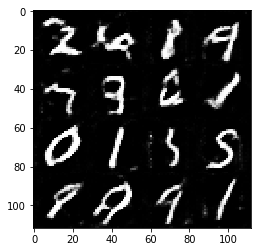

Epoch 2/2, Discriminator Loss: 1.4795, Generator Loss: 0.7282
Epoch 2/2, Discriminator Loss: 1.4638, Generator Loss: 0.8212
Epoch 2/2, Discriminator Loss: 1.5031, Generator Loss: 0.7777
Epoch 2/2, Discriminator Loss: 1.4461, Generator Loss: 0.8097


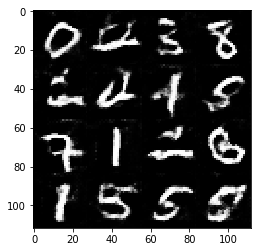

Epoch 2/2, Discriminator Loss: 1.4301, Generator Loss: 0.7300
Epoch 2/2, Discriminator Loss: 1.4546, Generator Loss: 0.6384
Epoch 2/2, Discriminator Loss: 1.4787, Generator Loss: 0.6528
Epoch 2/2, Discriminator Loss: 1.4397, Generator Loss: 0.8771


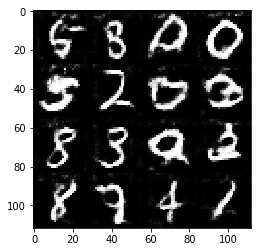

Epoch 2/2, Discriminator Loss: 1.4976, Generator Loss: 0.7123
Epoch 2/2, Discriminator Loss: 1.3938, Generator Loss: 0.6776
Epoch 2/2, Discriminator Loss: 1.5071, Generator Loss: 0.6693
Epoch 2/2, Discriminator Loss: 1.4660, Generator Loss: 0.7504


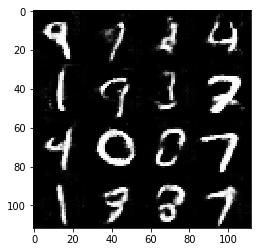

Epoch 2/2, Discriminator Loss: 1.4870, Generator Loss: 0.6782
Epoch 2/2, Discriminator Loss: 1.4741, Generator Loss: 0.7700
Epoch 2/2, Discriminator Loss: 1.5201, Generator Loss: 0.7625
Epoch 2/2, Discriminator Loss: 1.6144, Generator Loss: 0.6918


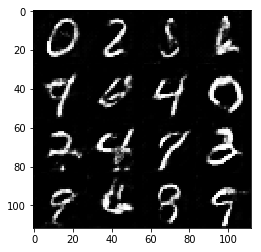

Epoch 2/2, Discriminator Loss: 1.4320, Generator Loss: 0.7094
Epoch 2/2, Discriminator Loss: 1.5311, Generator Loss: 0.6239
Epoch 2/2, Discriminator Loss: 1.4377, Generator Loss: 0.8551
Epoch 2/2, Discriminator Loss: 1.3401, Generator Loss: 0.7924


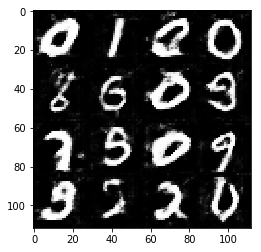

Epoch 2/2, Discriminator Loss: 1.4066, Generator Loss: 0.6617
Epoch 2/2, Discriminator Loss: 1.3916, Generator Loss: 0.8251
Epoch 2/2, Discriminator Loss: 1.4252, Generator Loss: 0.7650
Epoch 2/2, Discriminator Loss: 1.4557, Generator Loss: 0.6601


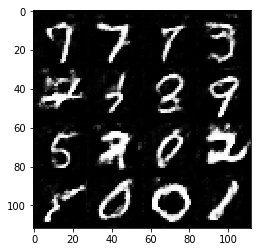

Epoch 2/2, Discriminator Loss: 1.4859, Generator Loss: 0.6374
Epoch 2/2, Discriminator Loss: 1.5455, Generator Loss: 0.8386
Epoch 2/2, Discriminator Loss: 1.5325, Generator Loss: 0.6245
Epoch 2/2, Discriminator Loss: 1.4567, Generator Loss: 0.6089


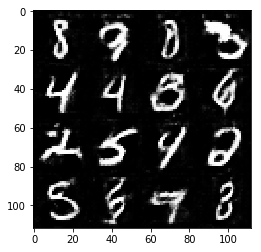

Epoch 2/2, Discriminator Loss: 1.4013, Generator Loss: 0.6804
Epoch 2/2, Discriminator Loss: 1.6306, Generator Loss: 0.7050
Result after training:


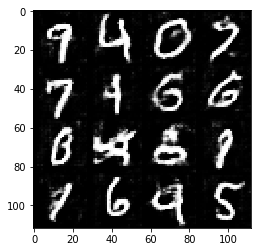

In [66]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1, Discriminator Loss: 2.1559, Generator Loss: 0.1089
Epoch 1/1, Discriminator Loss: 1.8386, Generator Loss: 0.2460
Epoch 1/1, Discriminator Loss: 1.8508, Generator Loss: 0.3203
Epoch 1/1, Discriminator Loss: 1.5321, Generator Loss: 0.3031


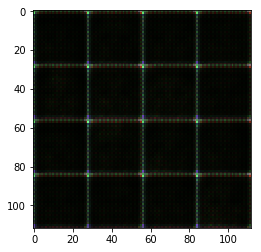

Epoch 1/1, Discriminator Loss: 1.5327, Generator Loss: 0.4467
Epoch 1/1, Discriminator Loss: 1.5542, Generator Loss: 0.3718
Epoch 1/1, Discriminator Loss: 1.5470, Generator Loss: 0.4327
Epoch 1/1, Discriminator Loss: 1.4935, Generator Loss: 0.3982


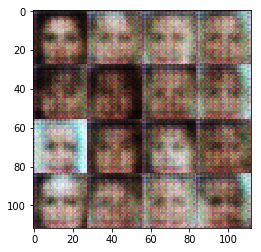

Epoch 1/1, Discriminator Loss: 1.7347, Generator Loss: 0.3709
Epoch 1/1, Discriminator Loss: 1.6076, Generator Loss: 0.3909
Epoch 1/1, Discriminator Loss: 1.4293, Generator Loss: 0.4273
Epoch 1/1, Discriminator Loss: 1.4101, Generator Loss: 0.4260


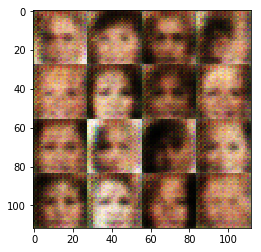

Epoch 1/1, Discriminator Loss: 1.4453, Generator Loss: 0.4553
Epoch 1/1, Discriminator Loss: 1.3428, Generator Loss: 0.4362
Epoch 1/1, Discriminator Loss: 1.3362, Generator Loss: 0.4640
Epoch 1/1, Discriminator Loss: 1.4052, Generator Loss: 0.4753


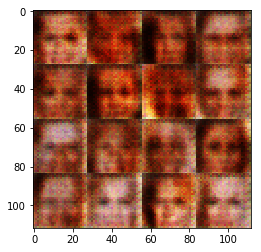

Epoch 1/1, Discriminator Loss: 1.4730, Generator Loss: 0.4337
Epoch 1/1, Discriminator Loss: 1.4817, Generator Loss: 0.4337
Epoch 1/1, Discriminator Loss: 1.3833, Generator Loss: 0.4335
Epoch 1/1, Discriminator Loss: 1.5130, Generator Loss: 0.3974


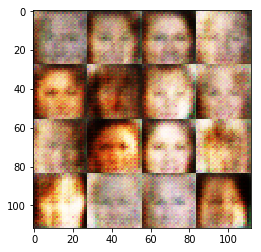

Epoch 1/1, Discriminator Loss: 1.4501, Generator Loss: 0.4108
Epoch 1/1, Discriminator Loss: 1.5115, Generator Loss: 0.4167
Epoch 1/1, Discriminator Loss: 1.4536, Generator Loss: 0.4432
Epoch 1/1, Discriminator Loss: 1.4080, Generator Loss: 0.5086


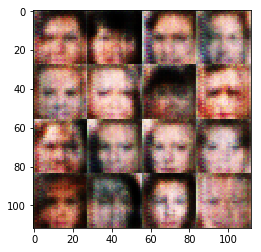

Epoch 1/1, Discriminator Loss: 1.4469, Generator Loss: 0.4399
Epoch 1/1, Discriminator Loss: 1.3567, Generator Loss: 0.4975
Epoch 1/1, Discriminator Loss: 1.3889, Generator Loss: 0.4535
Epoch 1/1, Discriminator Loss: 1.3879, Generator Loss: 0.4527


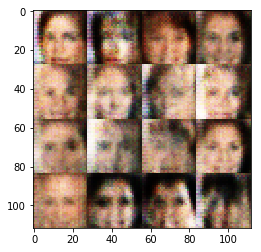

Epoch 1/1, Discriminator Loss: 1.4567, Generator Loss: 0.4355
Epoch 1/1, Discriminator Loss: 1.3715, Generator Loss: 0.4692
Epoch 1/1, Discriminator Loss: 1.4052, Generator Loss: 0.4787
Epoch 1/1, Discriminator Loss: 1.3959, Generator Loss: 0.4813


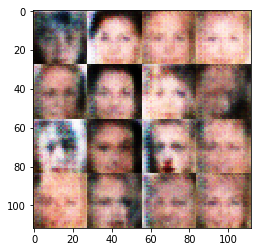

Epoch 1/1, Discriminator Loss: 1.4516, Generator Loss: 0.4276
Epoch 1/1, Discriminator Loss: 1.4329, Generator Loss: 0.4352
Epoch 1/1, Discriminator Loss: 1.4160, Generator Loss: 0.4886
Epoch 1/1, Discriminator Loss: 1.4259, Generator Loss: 0.4331


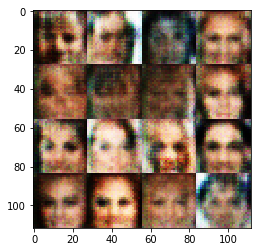

Epoch 1/1, Discriminator Loss: 1.4634, Generator Loss: 0.4558
Epoch 1/1, Discriminator Loss: 1.4431, Generator Loss: 0.4260
Epoch 1/1, Discriminator Loss: 1.3777, Generator Loss: 0.4235
Epoch 1/1, Discriminator Loss: 1.3797, Generator Loss: 0.4325


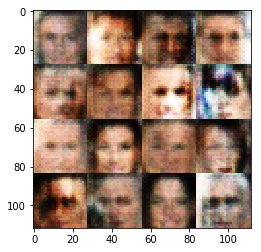

Epoch 1/1, Discriminator Loss: 1.3753, Generator Loss: 0.4686
Epoch 1/1, Discriminator Loss: 1.4411, Generator Loss: 0.4248
Epoch 1/1, Discriminator Loss: 1.4050, Generator Loss: 0.4422
Epoch 1/1, Discriminator Loss: 1.3716, Generator Loss: 0.4682


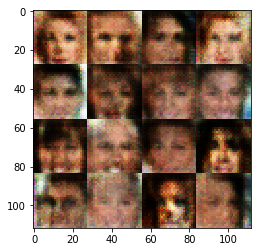

Epoch 1/1, Discriminator Loss: 1.4435, Generator Loss: 0.4197
Epoch 1/1, Discriminator Loss: 1.3510, Generator Loss: 0.4534
Epoch 1/1, Discriminator Loss: 1.4269, Generator Loss: 0.4959
Epoch 1/1, Discriminator Loss: 1.3938, Generator Loss: 0.4587


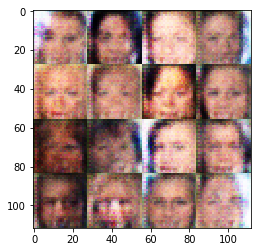

Epoch 1/1, Discriminator Loss: 1.4883, Generator Loss: 0.4084
Epoch 1/1, Discriminator Loss: 1.3854, Generator Loss: 0.5086
Epoch 1/1, Discriminator Loss: 1.4157, Generator Loss: 0.4806
Epoch 1/1, Discriminator Loss: 1.4109, Generator Loss: 0.4522


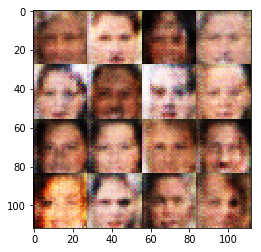

Epoch 1/1, Discriminator Loss: 1.4487, Generator Loss: 0.4562
Epoch 1/1, Discriminator Loss: 1.3400, Generator Loss: 0.4898
Epoch 1/1, Discriminator Loss: 1.3631, Generator Loss: 0.4621
Epoch 1/1, Discriminator Loss: 1.3771, Generator Loss: 0.4667


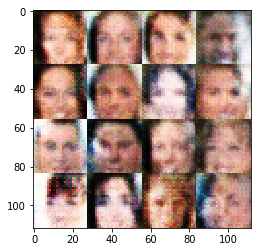

Epoch 1/1, Discriminator Loss: 1.4201, Generator Loss: 0.4787
Epoch 1/1, Discriminator Loss: 1.3973, Generator Loss: 0.4765
Epoch 1/1, Discriminator Loss: 1.3622, Generator Loss: 0.4799
Epoch 1/1, Discriminator Loss: 1.4152, Generator Loss: 0.4450


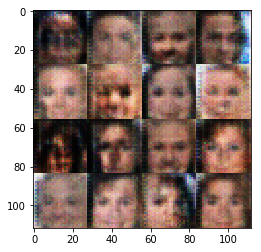

Epoch 1/1, Discriminator Loss: 1.3750, Generator Loss: 0.4993
Epoch 1/1, Discriminator Loss: 1.4071, Generator Loss: 0.4178
Epoch 1/1, Discriminator Loss: 1.3656, Generator Loss: 0.4968
Epoch 1/1, Discriminator Loss: 1.4056, Generator Loss: 0.4428


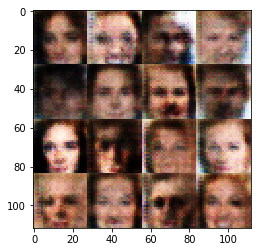

Epoch 1/1, Discriminator Loss: 1.3413, Generator Loss: 0.4947
Epoch 1/1, Discriminator Loss: 1.3597, Generator Loss: 0.4727
Epoch 1/1, Discriminator Loss: 1.3394, Generator Loss: 0.5100
Epoch 1/1, Discriminator Loss: 1.3504, Generator Loss: 0.4747


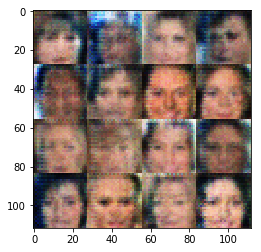

Epoch 1/1, Discriminator Loss: 1.3802, Generator Loss: 0.4803
Epoch 1/1, Discriminator Loss: 1.4223, Generator Loss: 0.4840
Epoch 1/1, Discriminator Loss: 1.3964, Generator Loss: 0.4827
Epoch 1/1, Discriminator Loss: 1.3856, Generator Loss: 0.4939


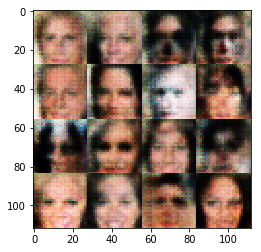

Epoch 1/1, Discriminator Loss: 1.3384, Generator Loss: 0.4786
Epoch 1/1, Discriminator Loss: 1.3739, Generator Loss: 0.4650
Epoch 1/1, Discriminator Loss: 1.3667, Generator Loss: 0.4626
Epoch 1/1, Discriminator Loss: 1.3560, Generator Loss: 0.4875


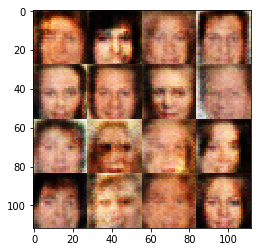

Epoch 1/1, Discriminator Loss: 1.3329, Generator Loss: 0.4880
Epoch 1/1, Discriminator Loss: 1.3633, Generator Loss: 0.4529
Epoch 1/1, Discriminator Loss: 1.4093, Generator Loss: 0.4676
Epoch 1/1, Discriminator Loss: 1.3645, Generator Loss: 0.4937


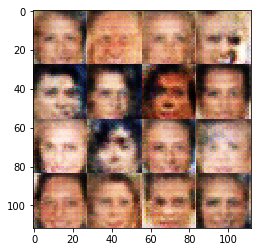

Epoch 1/1, Discriminator Loss: 1.3532, Generator Loss: 0.4843
Epoch 1/1, Discriminator Loss: 1.3701, Generator Loss: 0.4644
Epoch 1/1, Discriminator Loss: 1.3175, Generator Loss: 0.4447
Epoch 1/1, Discriminator Loss: 1.3857, Generator Loss: 0.4977


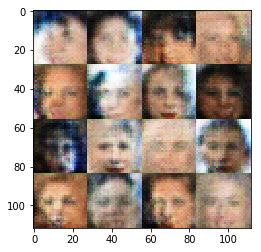

Epoch 1/1, Discriminator Loss: 1.3641, Generator Loss: 0.4821
Epoch 1/1, Discriminator Loss: 1.3450, Generator Loss: 0.4797
Epoch 1/1, Discriminator Loss: 1.3497, Generator Loss: 0.4683
Epoch 1/1, Discriminator Loss: 1.3800, Generator Loss: 0.4849


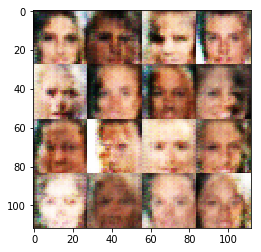

Epoch 1/1, Discriminator Loss: 1.3345, Generator Loss: 0.5218
Epoch 1/1, Discriminator Loss: 1.3390, Generator Loss: 0.4800
Epoch 1/1, Discriminator Loss: 1.3369, Generator Loss: 0.4908
Epoch 1/1, Discriminator Loss: 1.3447, Generator Loss: 0.4924


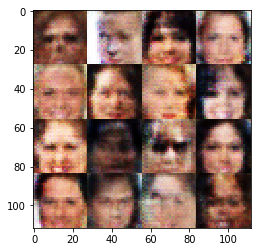

Epoch 1/1, Discriminator Loss: 1.3295, Generator Loss: 0.4811
Epoch 1/1, Discriminator Loss: 1.2841, Generator Loss: 0.4903
Epoch 1/1, Discriminator Loss: 1.3745, Generator Loss: 0.4762
Epoch 1/1, Discriminator Loss: 1.3847, Generator Loss: 0.4886


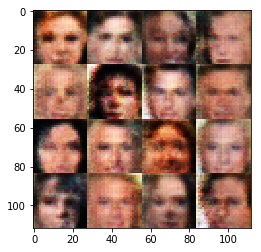

Epoch 1/1, Discriminator Loss: 1.3353, Generator Loss: 0.4802
Epoch 1/1, Discriminator Loss: 1.3644, Generator Loss: 0.4617
Epoch 1/1, Discriminator Loss: 1.3270, Generator Loss: 0.4912
Epoch 1/1, Discriminator Loss: 1.3607, Generator Loss: 0.4715


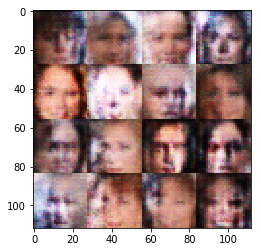

Epoch 1/1, Discriminator Loss: 1.3445, Generator Loss: 0.4594
Epoch 1/1, Discriminator Loss: 1.3828, Generator Loss: 0.5002
Epoch 1/1, Discriminator Loss: 1.3652, Generator Loss: 0.4741
Epoch 1/1, Discriminator Loss: 1.3647, Generator Loss: 0.4814


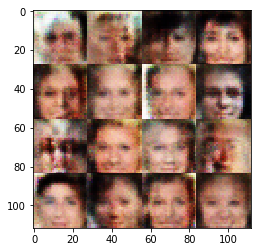

Epoch 1/1, Discriminator Loss: 1.3494, Generator Loss: 0.4629
Epoch 1/1, Discriminator Loss: 1.3580, Generator Loss: 0.4899
Epoch 1/1, Discriminator Loss: 1.3464, Generator Loss: 0.4998
Epoch 1/1, Discriminator Loss: 1.3611, Generator Loss: 0.4933


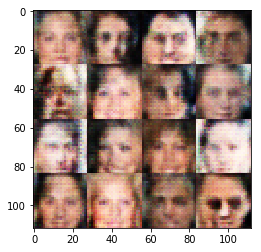

Epoch 1/1, Discriminator Loss: 1.3373, Generator Loss: 0.4602
Epoch 1/1, Discriminator Loss: 1.3343, Generator Loss: 0.4657
Epoch 1/1, Discriminator Loss: 1.3035, Generator Loss: 0.4916
Epoch 1/1, Discriminator Loss: 1.3302, Generator Loss: 0.5023


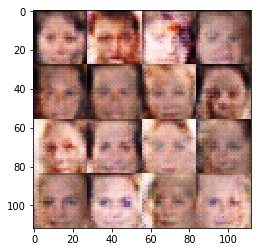

Epoch 1/1, Discriminator Loss: 1.3546, Generator Loss: 0.4474
Epoch 1/1, Discriminator Loss: 1.3689, Generator Loss: 0.4645
Epoch 1/1, Discriminator Loss: 1.3657, Generator Loss: 0.5061
Epoch 1/1, Discriminator Loss: 1.3702, Generator Loss: 0.4589


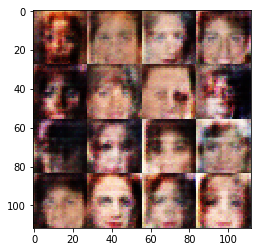

Epoch 1/1, Discriminator Loss: 1.3745, Generator Loss: 0.4561
Epoch 1/1, Discriminator Loss: 1.3599, Generator Loss: 0.4809
Epoch 1/1, Discriminator Loss: 1.3580, Generator Loss: 0.4772
Epoch 1/1, Discriminator Loss: 1.3297, Generator Loss: 0.4823


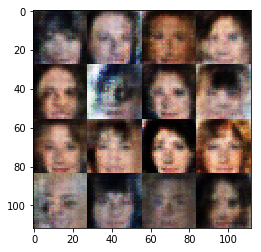

Epoch 1/1, Discriminator Loss: 1.3228, Generator Loss: 0.4839
Epoch 1/1, Discriminator Loss: 1.3267, Generator Loss: 0.5096
Epoch 1/1, Discriminator Loss: 1.3648, Generator Loss: 0.4517
Epoch 1/1, Discriminator Loss: 1.3316, Generator Loss: 0.4594


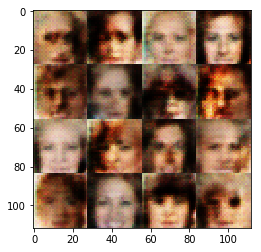

Epoch 1/1, Discriminator Loss: 1.3382, Generator Loss: 0.4914
Epoch 1/1, Discriminator Loss: 1.3385, Generator Loss: 0.4873
Epoch 1/1, Discriminator Loss: 1.3328, Generator Loss: 0.4746
Epoch 1/1, Discriminator Loss: 1.3282, Generator Loss: 0.4755


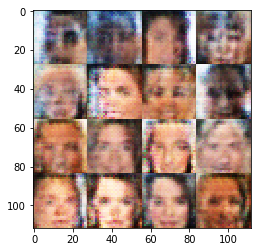

Epoch 1/1, Discriminator Loss: 1.3288, Generator Loss: 0.4753
Epoch 1/1, Discriminator Loss: 1.3425, Generator Loss: 0.4672
Epoch 1/1, Discriminator Loss: 1.3631, Generator Loss: 0.4631
Epoch 1/1, Discriminator Loss: 1.3600, Generator Loss: 0.4757


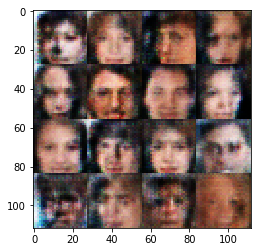

Epoch 1/1, Discriminator Loss: 1.3264, Generator Loss: 0.4956
Epoch 1/1, Discriminator Loss: 1.3313, Generator Loss: 0.5051
Epoch 1/1, Discriminator Loss: 1.3171, Generator Loss: 0.4879
Epoch 1/1, Discriminator Loss: 1.3594, Generator Loss: 0.4708


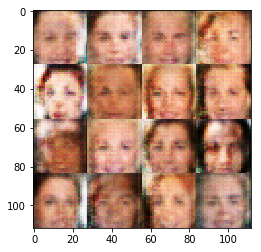

Epoch 1/1, Discriminator Loss: 1.3204, Generator Loss: 0.4804
Epoch 1/1, Discriminator Loss: 1.3602, Generator Loss: 0.4651
Epoch 1/1, Discriminator Loss: 1.3509, Generator Loss: 0.4770
Epoch 1/1, Discriminator Loss: 1.3459, Generator Loss: 0.5054


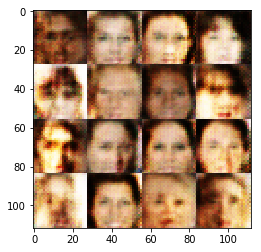

Epoch 1/1, Discriminator Loss: 1.3324, Generator Loss: 0.4882
Epoch 1/1, Discriminator Loss: 1.3047, Generator Loss: 0.4520
Epoch 1/1, Discriminator Loss: 1.3573, Generator Loss: 0.4391
Epoch 1/1, Discriminator Loss: 1.3626, Generator Loss: 0.4927


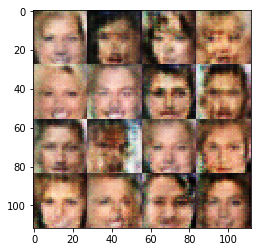

Epoch 1/1, Discriminator Loss: 1.3506, Generator Loss: 0.4741
Epoch 1/1, Discriminator Loss: 1.3150, Generator Loss: 0.4728
Epoch 1/1, Discriminator Loss: 1.3693, Generator Loss: 0.4830
Epoch 1/1, Discriminator Loss: 1.3512, Generator Loss: 0.4712


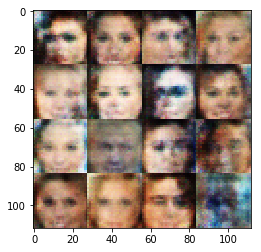

Epoch 1/1, Discriminator Loss: 1.3897, Generator Loss: 0.5009
Epoch 1/1, Discriminator Loss: 1.3433, Generator Loss: 0.4841
Epoch 1/1, Discriminator Loss: 1.3502, Generator Loss: 0.4860
Epoch 1/1, Discriminator Loss: 1.3613, Generator Loss: 0.4801


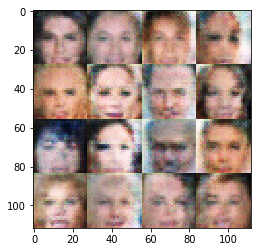

Epoch 1/1, Discriminator Loss: 1.3593, Generator Loss: 0.5009
Epoch 1/1, Discriminator Loss: 1.3812, Generator Loss: 0.4801
Epoch 1/1, Discriminator Loss: 1.3509, Generator Loss: 0.4666
Epoch 1/1, Discriminator Loss: 1.3576, Generator Loss: 0.4806


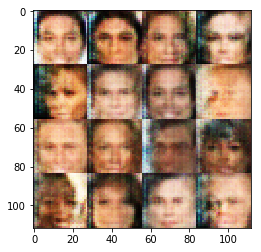

Epoch 1/1, Discriminator Loss: 1.3423, Generator Loss: 0.4922
Epoch 1/1, Discriminator Loss: 1.3534, Generator Loss: 0.4906
Epoch 1/1, Discriminator Loss: 1.3209, Generator Loss: 0.4573
Epoch 1/1, Discriminator Loss: 1.3518, Generator Loss: 0.4952


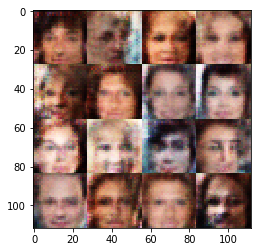

Epoch 1/1, Discriminator Loss: 1.3461, Generator Loss: 0.4805
Epoch 1/1, Discriminator Loss: 1.3510, Generator Loss: 0.4862
Epoch 1/1, Discriminator Loss: 1.3413, Generator Loss: 0.4648
Epoch 1/1, Discriminator Loss: 1.3431, Generator Loss: 0.4771


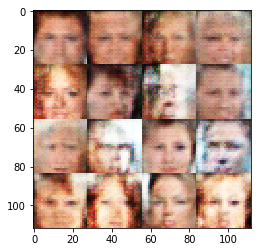

Epoch 1/1, Discriminator Loss: 1.3456, Generator Loss: 0.4634
Epoch 1/1, Discriminator Loss: 1.3685, Generator Loss: 0.4970
Epoch 1/1, Discriminator Loss: 1.3328, Generator Loss: 0.4561
Epoch 1/1, Discriminator Loss: 1.3413, Generator Loss: 0.4822


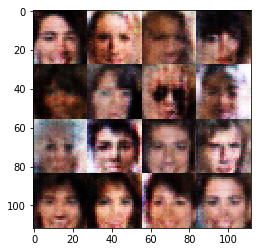

Epoch 1/1, Discriminator Loss: 1.3697, Generator Loss: 0.4834
Epoch 1/1, Discriminator Loss: 1.3423, Generator Loss: 0.5025
Epoch 1/1, Discriminator Loss: 1.3470, Generator Loss: 0.5022
Epoch 1/1, Discriminator Loss: 1.3435, Generator Loss: 0.4757


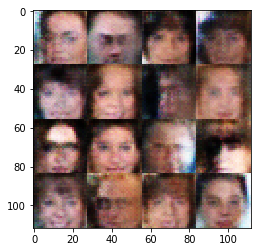

Epoch 1/1, Discriminator Loss: 1.3473, Generator Loss: 0.4678
Epoch 1/1, Discriminator Loss: 1.3432, Generator Loss: 0.4712
Epoch 1/1, Discriminator Loss: 1.3702, Generator Loss: 0.5067
Epoch 1/1, Discriminator Loss: 1.3688, Generator Loss: 0.4704


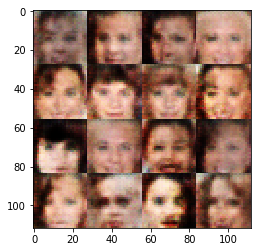

Epoch 1/1, Discriminator Loss: 1.3473, Generator Loss: 0.4728
Epoch 1/1, Discriminator Loss: 1.3167, Generator Loss: 0.4794
Epoch 1/1, Discriminator Loss: 1.3338, Generator Loss: 0.4666
Epoch 1/1, Discriminator Loss: 1.3254, Generator Loss: 0.4862


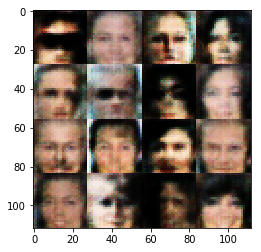

Epoch 1/1, Discriminator Loss: 1.3429, Generator Loss: 0.4714
Epoch 1/1, Discriminator Loss: 1.3435, Generator Loss: 0.4692
Epoch 1/1, Discriminator Loss: 1.3226, Generator Loss: 0.4857
Epoch 1/1, Discriminator Loss: 1.3443, Generator Loss: 0.4848


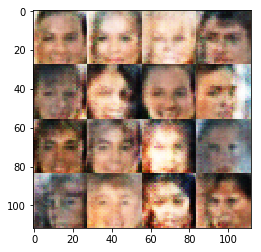

Epoch 1/1, Discriminator Loss: 1.3413, Generator Loss: 0.4995
Epoch 1/1, Discriminator Loss: 1.3498, Generator Loss: 0.4857
Epoch 1/1, Discriminator Loss: 1.3732, Generator Loss: 0.4851
Epoch 1/1, Discriminator Loss: 1.3617, Generator Loss: 0.4832


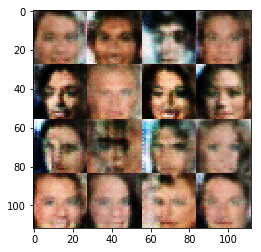

Epoch 1/1, Discriminator Loss: 1.3407, Generator Loss: 0.4895
Epoch 1/1, Discriminator Loss: 1.3273, Generator Loss: 0.4749
Epoch 1/1, Discriminator Loss: 1.3531, Generator Loss: 0.4629
Epoch 1/1, Discriminator Loss: 1.3347, Generator Loss: 0.4843


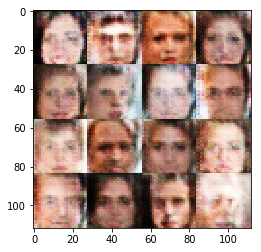

Epoch 1/1, Discriminator Loss: 1.3513, Generator Loss: 0.4859
Epoch 1/1, Discriminator Loss: 1.3511, Generator Loss: 0.4912
Epoch 1/1, Discriminator Loss: 1.3433, Generator Loss: 0.4806
Epoch 1/1, Discriminator Loss: 1.3320, Generator Loss: 0.5081


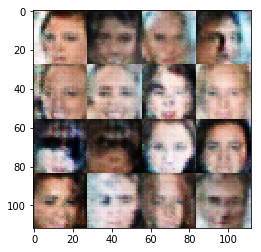

Epoch 1/1, Discriminator Loss: 1.3438, Generator Loss: 0.4730
Epoch 1/1, Discriminator Loss: 1.3331, Generator Loss: 0.4911
Epoch 1/1, Discriminator Loss: 1.3228, Generator Loss: 0.5204
Epoch 1/1, Discriminator Loss: 1.3318, Generator Loss: 0.4780


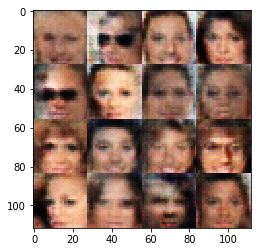

Epoch 1/1, Discriminator Loss: 1.3381, Generator Loss: 0.5090
Epoch 1/1, Discriminator Loss: 1.3561, Generator Loss: 0.4770
Epoch 1/1, Discriminator Loss: 1.3367, Generator Loss: 0.5015
Epoch 1/1, Discriminator Loss: 1.3540, Generator Loss: 0.4736


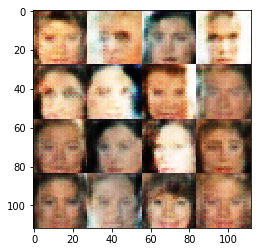

Epoch 1/1, Discriminator Loss: 1.3594, Generator Loss: 0.4763
Epoch 1/1, Discriminator Loss: 1.3503, Generator Loss: 0.4911
Epoch 1/1, Discriminator Loss: 1.3511, Generator Loss: 0.4978
Epoch 1/1, Discriminator Loss: 1.3428, Generator Loss: 0.4848


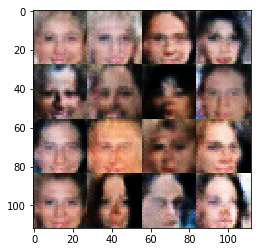

Epoch 1/1, Discriminator Loss: 1.3618, Generator Loss: 0.4725
Epoch 1/1, Discriminator Loss: 1.3398, Generator Loss: 0.4868
Epoch 1/1, Discriminator Loss: 1.3516, Generator Loss: 0.4929
Epoch 1/1, Discriminator Loss: 1.3449, Generator Loss: 0.4754


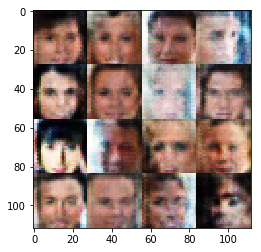

Epoch 1/1, Discriminator Loss: 1.3515, Generator Loss: 0.4818
Epoch 1/1, Discriminator Loss: 1.3458, Generator Loss: 0.4699
Epoch 1/1, Discriminator Loss: 1.3542, Generator Loss: 0.4954
Epoch 1/1, Discriminator Loss: 1.3279, Generator Loss: 0.4895


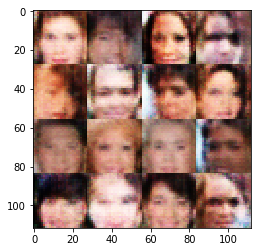

Epoch 1/1, Discriminator Loss: 1.3356, Generator Loss: 0.4733
Epoch 1/1, Discriminator Loss: 1.3563, Generator Loss: 0.4864
Epoch 1/1, Discriminator Loss: 1.3185, Generator Loss: 0.4949
Epoch 1/1, Discriminator Loss: 1.3358, Generator Loss: 0.4954


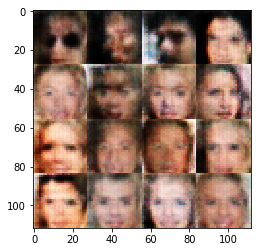

Epoch 1/1, Discriminator Loss: 1.3521, Generator Loss: 0.4836
Epoch 1/1, Discriminator Loss: 1.3544, Generator Loss: 0.4986
Epoch 1/1, Discriminator Loss: 1.3314, Generator Loss: 0.4937
Epoch 1/1, Discriminator Loss: 1.3404, Generator Loss: 0.4830


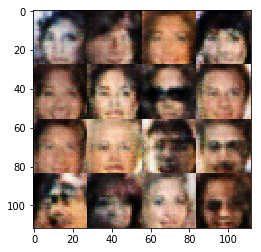

Epoch 1/1, Discriminator Loss: 1.3338, Generator Loss: 0.4840
Epoch 1/1, Discriminator Loss: 1.3394, Generator Loss: 0.4865
Epoch 1/1, Discriminator Loss: 1.3491, Generator Loss: 0.4733
Epoch 1/1, Discriminator Loss: 1.3526, Generator Loss: 0.4699


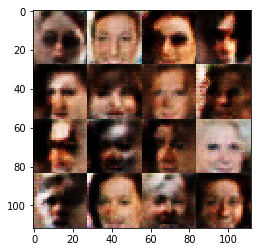

Epoch 1/1, Discriminator Loss: 1.3438, Generator Loss: 0.4704
Epoch 1/1, Discriminator Loss: 1.3504, Generator Loss: 0.4891
Epoch 1/1, Discriminator Loss: 1.3449, Generator Loss: 0.4805
Epoch 1/1, Discriminator Loss: 1.3563, Generator Loss: 0.4717


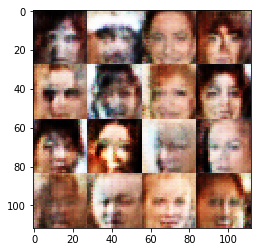

Epoch 1/1, Discriminator Loss: 1.3372, Generator Loss: 0.4825
Epoch 1/1, Discriminator Loss: 1.3270, Generator Loss: 0.4753
Epoch 1/1, Discriminator Loss: 1.3382, Generator Loss: 0.4791
Epoch 1/1, Discriminator Loss: 1.3499, Generator Loss: 0.4762


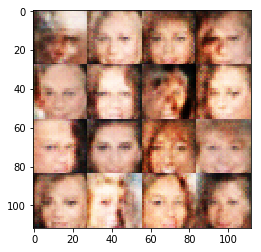

Epoch 1/1, Discriminator Loss: 1.3487, Generator Loss: 0.4742
Epoch 1/1, Discriminator Loss: 1.3237, Generator Loss: 0.4897
Epoch 1/1, Discriminator Loss: 1.3267, Generator Loss: 0.4845
Epoch 1/1, Discriminator Loss: 1.3305, Generator Loss: 0.4823


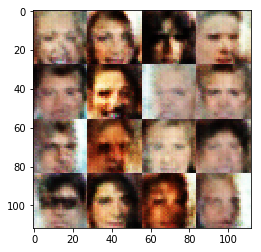

Epoch 1/1, Discriminator Loss: 1.3274, Generator Loss: 0.4751
Epoch 1/1, Discriminator Loss: 1.3604, Generator Loss: 0.4647
Epoch 1/1, Discriminator Loss: 1.3441, Generator Loss: 0.4619
Epoch 1/1, Discriminator Loss: 1.3386, Generator Loss: 0.4803


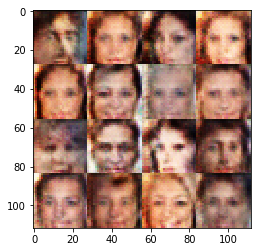

Epoch 1/1, Discriminator Loss: 1.3293, Generator Loss: 0.4906
Epoch 1/1, Discriminator Loss: 1.3291, Generator Loss: 0.4767
Epoch 1/1, Discriminator Loss: 1.3254, Generator Loss: 0.4955
Epoch 1/1, Discriminator Loss: 1.3476, Generator Loss: 0.4725


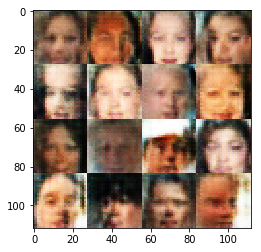

Epoch 1/1, Discriminator Loss: 1.3456, Generator Loss: 0.4878
Epoch 1/1, Discriminator Loss: 1.3547, Generator Loss: 0.4796
Epoch 1/1, Discriminator Loss: 1.3349, Generator Loss: 0.4693
Epoch 1/1, Discriminator Loss: 1.3419, Generator Loss: 0.4949


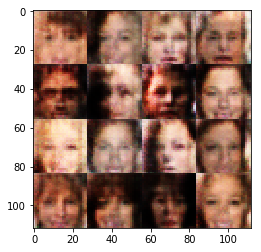

Epoch 1/1, Discriminator Loss: 1.3423, Generator Loss: 0.5055
Result after training:


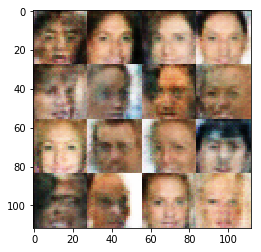

In [68]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.